# Hyperbolic Discounting

## Simulations

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import os, sys
here = os.getcwd()
sys.path.append(os.path.join(here, '..')) # needed to run from subfolder

from security_games.clinch import clinch, round_clinch_result, BatchedClinchThenCommit
from security_games.utils import SSG, RepeatedSSG, Polytope, gen_non_myopic_with_bounded_lookahead_oracle, RepeatedSSGAlg
from security_games.multi_threaded_clinch import MultiThreadedClinch

In [5]:
def gen_simplex_SSG(n_targets: int, v_low: float, v_high: float) -> SSG:
    dimension = n_targets
    simplex_A = np.concatenate([-np.eye(dimension), np.ones((1, dimension))])
    simplex_b = np.concatenate([np.zeros((dimension, 1)), np.ones((1, 1))])
    simplex = Polytope(simplex_A, simplex_b)

    # values = [np.random.uniform(0.9995, 1) for _ in range(n_targets)]
    values_1 = [np.random.uniform(low=v_low, high=v_high) for _ in range(n_targets)]
    values_2 = [np.random.uniform(low=v_low, high=v_high) for _ in range(n_targets)]

    return SSG(
        n_targets,
        simplex,
        np.array([[0.0, value] for value in values_1]).T,
        np.array([[value, 0.0] for value in values_2]).T,
    )

In [6]:
np.random.seed(1234)

# params for generating SSGs and benchmark solutions
n_games = 5
n_targets = 3
v_low = 0.25
v_high = 0.75
W = v_low / (v_low + (n_targets - 1)*v_high)
benchmark_precision = 1e-4

In [7]:
ssgs = []
benchmark_solutions = []
benchmark_payoffs = []
null_payoffs = []
games = []

for i in range(n_games):
    ssg = gen_simplex_SSG(n_targets=n_targets, v_low=v_low, v_high=v_high)
    ssgs.append(ssg)

    game = RepeatedSSG(ssg, 0.5, discounting_type="hyperbolic")
    # choice of discount factor insubstantial, not used below and will be overwritten
    games.append(game)

    get_response = lambda x,_: ssg.get_best_response(x)
    sol = BatchedClinchThenCommit(game, 
                                  minimum_width=W, 
                                  time_horizon=1000, # increase if search result not found
                                  is_simplex=True,
                                  get_response=get_response,
                                  batch_size=1,
                                  myopic=True,
                                  search_accuracy=benchmark_precision).run().search_result

    benchmark_solutions.append(sol)
    benchmark = ssg.get_leader_payoff(sol)
    benchmark_payoffs.append(benchmark)

    null_payoffs.append(ssg.get_leader_payoff(np.ones(n_targets)/n_targets))

In [8]:
agent_lookahead = 1 # only one non-myopic lookahead step needed for interesting behavior
agent_cutoff = 999999 # controls how far simulations are run into the future, could be cut down to improve performance
get_response = gen_non_myopic_with_bounded_lookahead_oracle(agent_lookahead, agent_cutoff)

In [9]:
T = 500
discount_factors = [1,2,3]
batch_sizes = [1, 2, 4, 8, 12]

In [10]:
time_horizons = np.arange(20, 501, 20)

# multi-threaded utilities
mt_utilities = {} # indexed by (game #, gamma, T) tuples
# single-threaded utilities
st_utilities = {} # indexed by (game #, gamma, T, batch_size) tuples

for i in range(n_games):
    print(f'game:{i}')
    print(f'null payoff:{null_payoffs[i]}')
    for gamma in discount_factors:
        print(f'gamma:{gamma}')
        for T in time_horizons:
            print(f'T:{T}')
            res = MultiThreadedClinch(games[i].reset(discount_factor=gamma),
                                      minimum_width=W,
                                      time_horizon=T,
                                      is_simplex=True,
                                      get_response=get_response,
                                      verbose=False).run()
            mt_utilities[(i,gamma,T)] = res.game.leader_utility
            completed_threads = [2**(j+1) for j in range(len(res.threads)) if res.threads[j].search_result is not None]
            if res.highest_completed_thread >= 0:
                best_result = res.threads[res.highest_completed_thread].search_result
                best_result_payoff = benchmark_payoffs[i] - ssgs[i].get_leader_payoff(best_result)
            else:
                best_result_payoff = "n/a"
            print(f'MT-U:{res.game.leader_utility}, completed thread delays: {completed_threads}, result payoff: {best_result_payoff}')
    
            for batch_size in batch_sizes:
                res = BatchedClinchThenCommit(games[i].reset(discount_factor=gamma),
                                              minimum_width=W,
                                              time_horizon=T,
                                              is_simplex=True,
                                              get_response=get_response,
                                              batch_size=batch_size,
                                              verbose=False).run()
                st_utilities[(i,gamma,T,batch_size)] = res.game.leader_utility
                if res.search_result is None:
                    result_payoff = "n/a"
                else:
                    result_payoff = benchmark_payoffs[i] - ssgs[i].get_leader_payoff(res.search_result)
                print(f'B{batch_size}-U:{res.game.leader_utility}, search {"in progress" if res.search_result is None else "complete"}, result payoff: {result_payoff}')

game:0
null payoff:0.11525324172981538
gamma:1
T:20
MT-U:2.766331940668937, completed thread delays: [], result payoff: n/a
B1-U:2.7987038738343464, search in progress, result payoff: n/a
B2-U:3.305067230279396, search in progress, result payoff: n/a
B4-U:2.9253730020619644, search in progress, result payoff: n/a
B8-U:2.7506730909015076, search in progress, result payoff: n/a
B12-U:2.3805147404563907, search in progress, result payoff: n/a
T:40
MT-U:5.725019042042327, completed thread delays: [], result payoff: n/a
B1-U:6.155469980360019, search complete, result payoff: [0.09060637]
B2-U:5.624227288175145, search in progress, result payoff: n/a
B4-U:6.748469419341747, search in progress, result payoff: n/a
B8-U:5.778981117347106, search in progress, result payoff: n/a
B12-U:4.883267176955287, search in progress, result payoff: n/a
T:60
MT-U:9.947949799936325, completed thread delays: [], result payoff: n/a
B1-U:9.450158816342471, search complete, result payoff: [0.08960384]
B2-U:8.9483

In [12]:
mt_regret = {} # indexed by (game #, gamma, T) tuples
st_regret = {} # indexed by (game #, gamma, T, batch_size) tuples

for i in range(n_games):
    benchmark = benchmark_payoffs[i]
    for gamma in discount_factors:
        for T in time_horizons:
            mt_regret[(i,gamma,T)] = T*benchmark - mt_utilities[(i,gamma,T)]
            for batch_size in batch_sizes:
                st_regret[(i,gamma,T,batch_size)] = T*benchmark - st_utilities[(i,gamma,T,batch_size)]

In [36]:
#np.save('hyperbolic_T500_B-1-2-4-8-12.npy', (mt_regret, st_regret))
#np.load('hyperbolic_T500_B-1-2-4-8-12.npy', (mt_regret, st_regret))

## Plots (Figure EC.2 of EC.4.2)

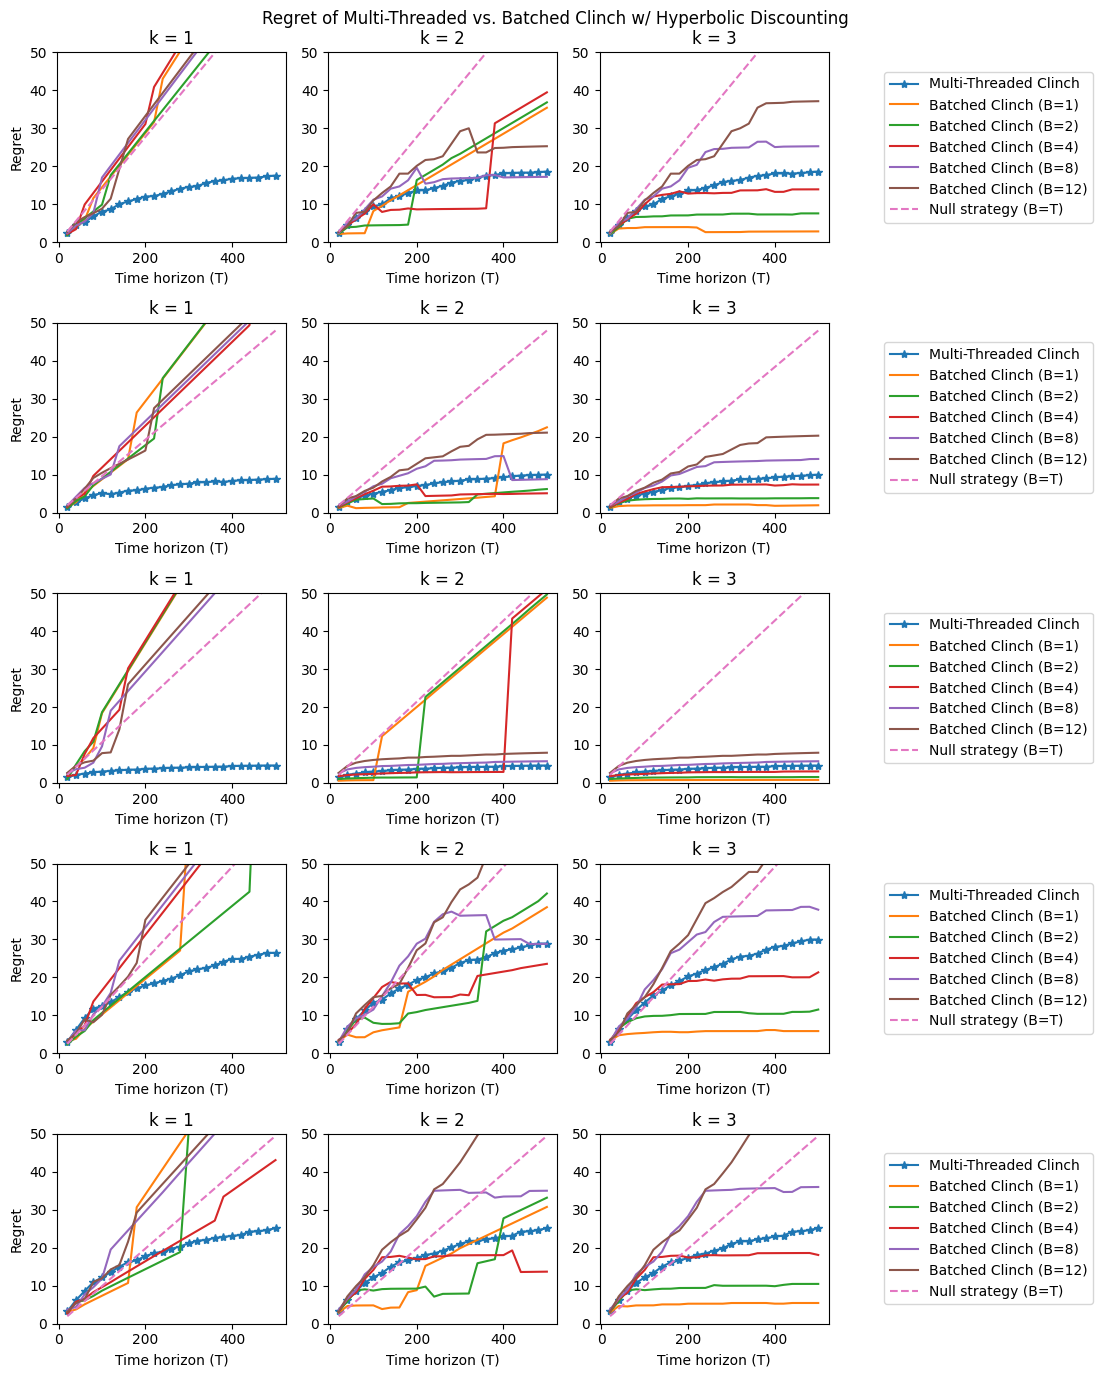

In [35]:
y_lim_list = [50, 50, 50, 50, 50]

fig, axes = plt.subplots(len(games),len(discount_factors)+1, figsize=(14/1.25,len(games)*3.5/1.25))

for i in range(len(games)):
    for (j,gamma) in enumerate(discount_factors): 
        x = time_horizons
        y_mt = [mt_regret[(i,gamma,T)] for T in time_horizons]
        y_null = [T*benchmark_payoffs[i] - T*ssgs[i].get_leader_payoff(np.ones(n_targets)/n_targets) for T in time_horizons]
        y_st_table = {}
    
        batch_sizes = sorted(list(set([key[3] for key in st_regret.keys() if key[1] == gamma])))
        for batch_size in batch_sizes:
            y_st_table[batch_size] = [st_regret[(i,gamma,T,batch_size)] for T in time_horizons]
        
        axes[i][j].plot(x,y_mt,"-*",label="Multi-Threaded Clinch")
        
        for (k,batch_size) in enumerate(batch_sizes):
            axes[i][j].plot(x,y_st_table[batch_size],label=f"Batched Clinch (B={batch_size})")
        axes[i][j].plot(x,y_null,"--",label="Null strategy (B=T)")
        axes[i][j].set_xlabel("Time horizon (T)")
        if j == 0:
            axes[i][j].set_ylabel("Regret")
        axes[i][j].set_ylim([0,y_lim_list[i]])
        axes[i][j].set_title(f"k = {gamma}")
        if j == 0:
            handles, labels = axes[i][j].get_legend_handles_labels()
    
    axes[i][-1].set_axis_off()
    axes[i][-1].legend(handles, labels, loc='right')

plt.suptitle('Regret of Multi-Threaded vs. Batched Clinch w/ Hyperbolic Discounting')
plt.tight_layout()

In [2]:
#fig.savefig('multi-threaded-hyperbolic-plots.pdf')